# Homework 3

Vyas Ramasubramani

## Simulation
Get all of the simulation setup completed

In [1]:
import warnings
import numpy as np
from math import factorial
import time
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.core.display import HTML
%matplotlib inline

### Define helper functions
These are all based on what was provided in the lj_start.py script, but most of them have been modified to use more pure numpy code in order to speed them up.
In particular, the compute_forces and compute_potential_energy functions have been significantly modified internally and verified against the original implementations.

In [2]:
def initialize_positions_and_velocities(Nx, Ny, L):
    N = Nx*Ny
    vx = np.zeros(N)
    vy = np.zeros(N)
    rx = np.zeros(N)
    ry = np.zeros(N)
    
    dx = L / Nx
    dy = L / Ny
    
    np.random.seed(0)
    for i in range(Nx):
        for j in range(Ny):
            rx[i * Ny + j] = dx * (i + 0.5)
            ry[i * Ny + j] = dy * (j + 0.5)

            u = np.random.random()  # This is box muller
            v = np.random.random()
            vx[i * Ny + j] = np.sqrt(
                -2 * np.log(u)) * np.cos(2. * np.pi * v)
            vy[i * Ny + j] = np.sqrt(
                -2 * np.log(u)) * np.sin(2. * np.pi * v)
    # subtract net velocity to avoid global drift
    vxav = sum(vx) / vx.size
    vyav = sum(vy) / vy.size
    vx -= vxav
    vy -= vyav
    
    return rx, ry, vx, vy
    
def force(rsq, sigma=1.0, epsilon=1.0):
    # Allow zeros here and deal with them elsewhere
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.sqrt(rsq)
        rsqinv = sigma**2 / rsq
        r6inv = rsqinv * rsqinv * rsqinv
        return -(24 * epsilon / rsq) * r6inv * (1 - 2 * r6inv)

def potential(rsq, sigma=1.0, epsilon=1.0):
    # Allow zeros here and deal with them elsewhere
    with np.errstate(divide='ignore', invalid='ignore'):
        rsqinv = sigma**2 / rsq
        r6inv = rsqinv * rsqinv * rsqinv
        return -4 * epsilon * r6inv * (1 - r6inv)

def compute_kinetic_energy(vx, vy):
    return 0.5 * np.sum(vx * vx + vy * vy)

def min_image(dx, dy, L):
    dx = np.copy(dx)
    dy = np.copy(dy)
    dx[dx > L / 2.] -= L
    dx[dx < -L / 2.] += L
    dy[dy > L / 2.] -= L
    dy[dy < -L / 2.] += L
    return dx, dy

def compute_potential_energy(rx, ry, rcut, L):
    rcutsq = rcut * rcut
    # shift the potential to avoid jump at rc
    rcutv = potential(rcutsq)
    
    dx = rx[:, np.newaxis] - rx[np.newaxis, :]
    dy = ry[:, np.newaxis] - ry[np.newaxis, :]
    dx, dy = min_image(dx, dy, L)
    rsq = dx*dx + dy*dy
    
    Epot = np.where(np.logical_and(rsq > 0, rsq < rcutsq), 
                    potential(rsq) - rcutv, 0)
    return np.sum(Epot)/2

def compute_forces(rx, ry, N, L, rcut):
    rcutsq = rcut * rcut
    dx = rx[:, np.newaxis] - rx[np.newaxis, :]
    dy = ry[:, np.newaxis] - ry[np.newaxis, :]
    dx, dy = min_image(dx, dy, L)
    rsq = dx*dx + dy*dy
    dV_dr = np.where(np.logical_and(rsq > 0, rsq < rcutsq), 
                     force(rsq), 0)
    
    dV_drx = np.sum(dx*dV_dr, axis = 1)
    dV_dry = np.sum(dy*dV_dr, axis = 1)
    
    return dV_drx, dV_dry

def euler(rx, ry, vx, vy, dV_drx, dV_dry, deltat = 0.0001):
    deltat = 1e-4
    # update the positions
    rx_new = rx + deltat * vx
    ry_new = ry + deltat * vy

    # Modified to rebox internally for consistency with verlet
    rx_new, ry_new, x_rebox, y_rebox = rebox(rx_new, ry_new, L)
    
    # update the velocities
    vx_new = vx + deltat * dV_drx
    vy_new = vy + deltat * dV_dry
    
    return rx_new, ry_new, vx_new, vy_new, x_rebox, y_rebox
    
def verlet(timestep, rx, ry, vx, vy, dV_drx, dV_dry, N, L, rcut,
           deltat = 0.0001):
    # update the positions
    rx_new = rx + deltat * vx + 0.5 * dV_drx * deltat**2
    ry_new = ry + deltat * vy + 0.5 * dV_dry * deltat**2
    
    rx_new, ry_new, x_rebox, y_rebox = rebox(rx_new, ry_new, L)

    # Compute the new forces
    dV_drx_next, dV_dry_next = compute_forces(
        rx_new, ry_new, N, L, rcut)
    
    # update the velocities
    vx_new = vx + deltat * (dV_drx + dV_drx_next) * 0.5
    vy_new = vy + deltat * (dV_dry + dV_dry_next) * 0.5
    
    return rx_new, ry_new, vx_new, vy_new, x_rebox, y_rebox

# put back into box:
def rebox(rx, ry, L):
    rx = np.copy(rx)
    ry = np.copy(ry)
    x_rebox = np.zeros(len(rx))
    y_rebox = np.zeros(len(ry))
    
    ind = rx > L
    rx[ind] -= L
    x_rebox[ind] += 1
    
    ind = rx < 0
    rx[ind] += L
    x_rebox[ind] -= 1
    
    ind = ry > L
    ry[ind] -= L
    y_rebox[ind] += 1
    
    ind = ry < 0
    ry[ind] += L
    y_rebox[ind] -= 1
    
    return rx, ry, x_rebox, y_rebox

### Simulate function
This is a modified version of the main function provided in the original script.
Some unnecessary variables have been removed, but otherwise it is largely identical since the key changes were made in the underlying functions defined above.

In [4]:
def run_simulation(Nx, Ny, L, dt, Nstep, rcut, 
                   print_period = 100, method = "euler"):
    """Core function to run the MD simulation"""
    # Define 
    N = Nx*Ny
    rx = np.zeros([Nstep + 1, N])
    ry = np.zeros([Nstep + 1, N])
    vx = np.zeros([Nstep + 1, N])
    vy = np.zeros([Nstep + 1, N])
    x_rebox_count = np.zeros((Nstep + 1, N))
    y_rebox_count = np.zeros((Nstep + 1, N))

    # Initialize and run
    start = time.time()
    rx[0, :], ry[0, :], vx[0, :], vy[0, :] = \
        initialize_positions_and_velocities(Nx, Ny, L)
    for i in range(1, Nstep + 1):
        dV_drx, dV_dry = compute_forces(
            rx[i-1, :], ry[i-1, :], N, L, rcut)

        if method == 'euler':
            # propagate using forward Euler
            rx[i], ry[i], vx[i], vy[i], x_rebox, y_rebox = euler(
                rx[i-1, :], ry[i-1, :], vx[i-1, :], vy[i-1, :],
                dV_drx, dV_dry, deltat=dt)
            
        elif method == 'verlet':
            # propagate using Verlet 
            rx[i, :], ry[i, :], vx[i, :], vy[i, :], \
                x_rebox, y_rebox = verlet(
                i, rx[i-1, :], ry[i-1, :], vx[i-1, :], vy[i-1, :],
                dV_drx, dV_dry, N, L, rcut, deltat=dt)
            
        # Verlet may rebox internally
        for j in range(len(x_rebox)):
            x_rebox_count[i, j] += x_rebox[j]
            y_rebox_count[i, j] += y_rebox[j]

        # get some observables
        Epot = compute_potential_energy(rx[i, :], ry[i, :], rcut, L)
        Ekin = compute_kinetic_energy(vx[i, :], vy[i, :])

        # Using i-1 since I'm now including timestep 0
        if print_period is not None and not (i-1) % print_period:
            print("""Timestep {}/{}: T = {:2.4f}, \
K = {:2.4f}, H = {:2.4f}""".format(
                    i-1, Nstep, Epot, Ekin, Epot + Ekin))

    end = time.time()
    print("Total time for run = {}".format(end-start))
    
    return rx, ry, vx, vy, x_rebox_count, y_rebox_count


### Run simulation

In [5]:
# Crystal simulation parameters
Nx_crystal = 8
Ny_crystal = 8
# set particles onto a grid initially
N_crystal = Nx_crystal * Ny_crystal
L_crystal = 8
dt_crystal = 0.005
total_time_crystal = 150
Nstep_crystal = int(total_time_crystal/dt_crystal)
rcut_crystal = 2.5  # a usual choice for the cutoff radius

rx_crystal, ry_crystal, vx_crystal, vy_crystal, \
    x_rebox_count_crystal, y_rebox_count_crystal = run_simulation(
    Nx_crystal, Ny_crystal, L_crystal, dt_crystal, Nstep_crystal,
        rcut_crystal, print_period = 1000, method = 'verlet')

# Fluid simulation parameters
Nx_fluid = 8
Ny_fluid = 8
N_fluid = Nx_fluid * Ny_fluid  # set particles onto a grid initially
L_fluid = 40
dt_fluid = 0.005
total_time_fluid = 150
Nstep_fluid = int(total_time_fluid/dt_fluid)
rcut_fluid = 2.5  # a usual choice for the cutoff radius

rx_fluid, ry_fluid, vx_fluid, vy_fluid, \
    x_rebox_count_fluid, y_rebox_count_fluid = run_simulation(
    Nx_fluid, Ny_fluid, L_fluid, dt_fluid, Nstep_fluid, 
        rcut_fluid, print_period = 1000, method = 'verlet')

Timestep 0/30000: T = -60.4893, K = 58.1016, H = -2.3878
Timestep 1000/30000: T = -82.2544, K = 79.8750, H = -2.3794
Timestep 2000/30000: T = -80.3610, K = 78.0828, H = -2.2782
Timestep 3000/30000: T = -83.6764, K = 81.3266, H = -2.3497
Timestep 4000/30000: T = -84.3647, K = 81.9356, H = -2.4291
Timestep 5000/30000: T = -83.5591, K = 81.2360, H = -2.3231
Timestep 6000/30000: T = -67.0064, K = 64.7696, H = -2.2368
Timestep 7000/30000: T = -80.7248, K = 78.3786, H = -2.3462
Timestep 8000/30000: T = -75.4164, K = 73.0420, H = -2.3744
Timestep 9000/30000: T = -74.3968, K = 72.0752, H = -2.3216
Timestep 10000/30000: T = -97.5589, K = 95.1655, H = -2.3934
Timestep 11000/30000: T = -87.6162, K = 85.2483, H = -2.3679
Timestep 12000/30000: T = -85.7107, K = 83.3496, H = -2.3612
Timestep 13000/30000: T = -85.3379, K = 82.9666, H = -2.3713
Timestep 14000/30000: T = -88.9440, K = 86.5985, H = -2.3455
Timestep 15000/30000: T = -87.3552, K = 84.9479, H = -2.4072
Timestep 16000/30000: T = -86.6487, K

### Create video
To show the evolution of the system, we plot the trajectories over time.

**Note: The video will not display in a PDF; please run the notebook directly to see it.**

**Color Schemes courtesy of Shannon Moran (moranse)**.

In [10]:
L_crystal
rx_crystal

array([[ 0.5       ,  0.5       ,  0.5       , ...,  7.5       ,
         7.5       ,  7.5       ],
       [ 0.49881909,  0.49517522,  0.49602031, ...,  7.49908161,
         7.49486643,  7.49553093],
       [ 0.49771627,  0.49044954,  0.49210289, ...,  7.49809851,
         7.49000262,  7.4913001 ],
       ..., 
       [ 0.62588966,  0.99216742,  7.19510248, ...,  7.47004637,
         7.47007307,  0.2098758 ],
       [ 0.63171673,  0.98311747,  7.18810517, ...,  7.46257007,
         7.47604873,  0.20834616],
       [ 0.63770174,  0.97470255,  7.18137319, ...,  7.4541196 ,
         7.48199183,  0.20893663]])

In [13]:
lj_radius = 2**(1/6)/2
frame_interval = 80 # Break in video time between

# For consistent visualization, we want a comparable number 
# of frames for both fluid and crystal, so we have to compute 
# an appropriate sampling rate
num_frames = 100
sampling_rate_crystal = int(Nstep_crystal/num_frames)
sampling_rate_fluid = int(Nstep_fluid/num_frames)

fig, axes = plt.subplots(1, 2, figsize = (10, 5), dpi = 100);
fig.suptitle("MD Trajectories", size = 16)
axes[0].set_xlim([0, L_crystal])
axes[0].set_ylim([0, L_crystal])
axes[1].set_xlim([0, L_fluid])
axes[1].set_ylim([0, L_fluid])

def draw_frame(fn):
    axes[0].clear();
    axes[1].clear();
    
    axes[0].set_xlim([0, L_crystal])
    axes[0].set_ylim([0, L_crystal])
    axes[1].set_xlim([0, L_fluid])
    axes[1].set_ylim([0, L_fluid])
    
    time_crystal = fn*sampling_rate_crystal*dt_crystal
    time_fluid = fn*sampling_rate_fluid*dt_fluid
    axes[0].set_title("Crystal Trajectory: t = {0:4.1f}".format(
            time_crystal));
    axes[1].set_title("Fluid Trajectory: t = {0:4.1f}".format(
            time_fluid));
    
    for i in range(N_crystal):
        step_index_crystal = fn*sampling_rate_crystal
        if i % 2:
            patch_crystal = plt.Circle((
                    rx_crystal[step_index_crystal, i],
                    ry_crystal[step_index_crystal, i]), 
                       lj_radius, fc='#00274c');
        else:
            patch_crystal = plt.Circle((
                    rx_crystal[step_index_crystal, i],
                    ry_crystal[step_index_crystal, i]),
                       lj_radius, fc='#ffcb05');
        axes[0].add_patch(patch_crystal);
        
    for i in range(N_fluid):
        step_index_fluid = fn*sampling_rate_fluid
        if i % 2:
            patch_fluid = plt.Circle((
                    rx_fluid[step_index_fluid, i],
                    ry_fluid[step_index_fluid, i]),
                     lj_radius, fc='#00274c');
        else: 
            patch_fluid = plt.Circle((
                    rx_fluid[step_index_fluid, i],
                    ry_fluid[step_index_fluid, i]),
                     lj_radius, fc='#ffcb05');
        axes[1].add_patch(patch_fluid);
    return []

anim = animation.FuncAnimation(
    fig, draw_frame, frames = num_frames,
    interval = frame_interval, blit = True)
plt.close()
HTML(anim.to_html5_video())

Evidently, some rearrangement takes place in the crystal over long times but the overall ordering remains relatively constant.
Meanwhile, the fluid is completely free to move about.

## Measurements I: Identify Phases

### Calculate RMSD
The RMSD calculation is relatively simple, it is just a sum of squared changes from the initial point.

In [6]:
steps_to_thermalize = 2000

rx_unwrapped_crystal = rx_crystal + L_crystal*x_rebox_count_crystal
ry_unwrapped_crystal = ry_crystal + L_crystal*y_rebox_count_crystal
rmsd_crystal = np.sqrt(np.sum(
        (rx_unwrapped_crystal-rx_unwrapped_crystal[0, :])**2 + 
        (ry_unwrapped_crystal-ry_unwrapped_crystal[0, :])**2, 
        axis = 1)/N_crystal)

rx_unwrapped_fluid = rx_fluid + L_fluid*x_rebox_count_fluid
ry_unwrapped_fluid = ry_fluid + L_fluid*y_rebox_count_fluid
rmsd_fluid = np.sqrt(np.sum(
        (rx_unwrapped_fluid-rx_unwrapped_fluid[0, :])**2 + 
        (ry_unwrapped_fluid-ry_unwrapped_fluid[0, :])**2,
        axis = 1)/N_fluid)

### Compute diffusivity
To compute the diffusivity, we consider the post-thermalization data and perform a linear fit to determine the slope of the line.

In [7]:
d = 2 # The dimensionality

# Compute the best fit lines
x_crystal = rmsd_crystal[steps_to_thermalize:]
t_crystal = np.linspace(0, total_time_crystal, Nstep_crystal+1)
crystal_fit = np.polyfit(t_crystal[steps_to_thermalize:],
                         x_crystal, 1)
crystal_D = crystal_fit[0]/(2*d)
x_fluid = rmsd_fluid[steps_to_thermalize:]
t_fluid = np.linspace(0, total_time_fluid, Nstep_fluid+1)
fluid_fit = np.polyfit(t_fluid[steps_to_thermalize:],
                       x_fluid, 1)
fluid_D = fluid_fit[0]/(2*d)

### Plot RMSD and Diffusivity fit line
To compute the diffusivity, we consider the post-thermalization data and perform a linear fit to determine the slope of the line.

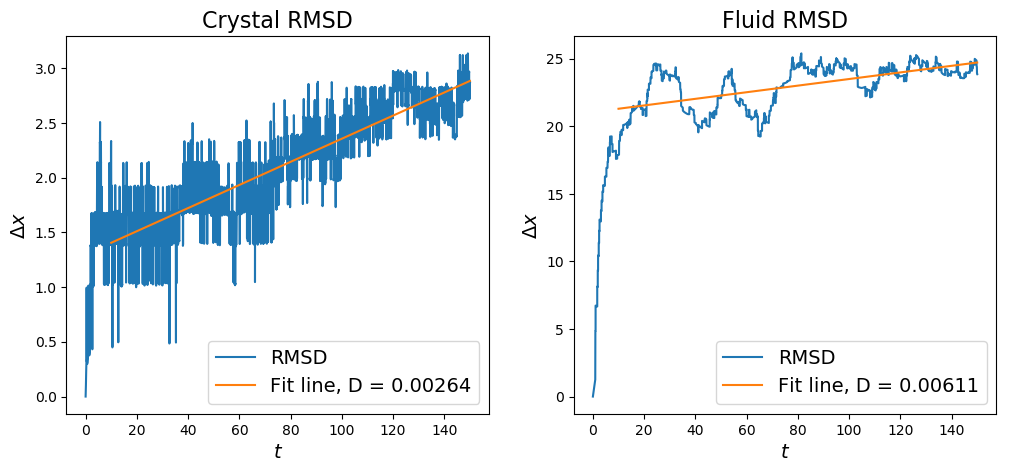

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

_ = axes[0].plot(t_crystal, rmsd_crystal, label = "RMSD")
_ = axes[0].set_xlabel("$t$", fontsize = 14)
_ = axes[0].set_ylabel("$\Delta x$", fontsize = 14)
_ = axes[0].set_title("Crystal RMSD", fontsize = 16)
_ = axes[0].plot(t_crystal[steps_to_thermalize:], 
                 2*d*crystal_D*t_crystal[
                    steps_to_thermalize:] + crystal_fit[1], 
                 label = "Fit line, D = {:1.5f}".format(
                    crystal_D))
_ = axes[0].legend(loc = 'best', fontsize = 14)

_ = axes[1].plot(t_fluid, rmsd_fluid, label = "RMSD")
_ = axes[1].set_xlabel("$t$", fontsize = 14)
_ = axes[1].set_ylabel("$\Delta x$", fontsize = 14)
_ = axes[1].set_title("Fluid RMSD", fontsize = 16)
_ = axes[1].plot(t_fluid[steps_to_thermalize:],
                 2*d*fluid_D*t_fluid[
                    steps_to_thermalize:] + fluid_fit[1],
                 label = "Fit line, D = {:1.5f}".format(
                    fluid_D))
_ = axes[1].legend(loc = 'best', fontsize = 14)

Evidently, the diffusion constant for the fluid is between 2 and 3 times larger than that for the crystal.
Additionally, the magnitude of the RMSD is much larger, indicating the difference in the two systems.

## Compute $g(r)$

### Get distances
To compute $g(r)$ we bin the points by their distances.
We must compute these distances pairwise for all particles.

In [9]:
Npair_crystal = int(factorial(N_crystal)/(
        factorial(2)*factorial(N_crystal-2)))
distances_crystal = np.empty(
    (Nstep_crystal+1-steps_to_thermalize, Npair_crystal))

counter = 0
for j in range(N_crystal):
    for k in range(j):
        dx_crystal = rx_crystal[
            steps_to_thermalize:, j] - rx_crystal[
            steps_to_thermalize:, k]
        dy_crystal = ry_crystal[
            steps_to_thermalize:, j] - ry_crystal[
            steps_to_thermalize:, k]
        min_image(dx_crystal, dy_crystal, L_crystal)
        
        # compute the distance
        distances_crystal[:, counter] = np.sqrt(
            dx_crystal * dx_crystal + dy_crystal * dy_crystal)
        counter += 1
distances_crystal = np.ravel(distances_crystal)

Npair_fluid = int(factorial(N_fluid)/(
        factorial(2)*factorial(N_fluid-2)))
distances_fluid = np.empty(
    (Nstep_fluid+1-steps_to_thermalize, Npair_fluid))

counter = 0
for j in range(N_fluid):
    for k in range(j):
        dx_fluid = rx_fluid[
            steps_to_thermalize:, j] - rx_fluid[
            steps_to_thermalize:, k]
        dy_fluid = ry_fluid[
            steps_to_thermalize:, j] - ry_fluid[
            steps_to_thermalize:, k]
        min_image(dx_fluid, dy_fluid, L_fluid)
        
        # compute the distance
        distances_fluid[:, counter] = np.sqrt(
            dx_fluid * dx_fluid + dy_fluid * dy_fluid)
        counter += 1
distances_fluid = np.ravel(distances_fluid)

### Collect histogram
Construct the histogram of the data.
In order to compute the true radial distribution function, we then have to normalize the bins by the ideal gas values, $\textit{i.e.}$ the number of particles we would expect to find in that region if the data were completely uncorrelated.
This corresponds to dividing by the density of the system multiplied by the area of the shell encompassed by a particle bin in the histogram.

In [10]:
num_bins = 20 # Use same number of bins for both systems

# Collect bins for crystal
dr_crystal = np.max(distances_crystal)/num_bins
bins_crystal = np.zeros(num_bins)
areas_crystal = np.zeros(num_bins)

bin_idx_crystal = np.floor(distances_crystal/dr_crystal).astype('int')
# Correct for the largest element that will overflow by 1
bin_idx_crystal[bin_idx_crystal == num_bins] -= 1
bins_crystal = np.bincount(bin_idx_crystal) / (
    10*(Nstep_crystal+1-steps_to_thermalize))

# Collect bins for fluid
dr_fluid = np.max(distances_fluid)/num_bins
bins_fluid = np.zeros(num_bins)
areas_fluid = np.zeros(num_bins)

bin_idx_fluid = np.floor(distances_fluid/dr_fluid).astype('int')
bin_idx_fluid[bin_idx_fluid == num_bins] -= 1
bins_fluid = np.bincount(bin_idx_fluid) / (
    10*(Nstep_fluid+1-steps_to_thermalize))

# Normalize each bin by area
for r in range(num_bins):
    bins_crystal[r] /= np.pi*(
        ((r+1)*dr_crystal)**2-(r*dr_crystal)**2)*(
        N_crystal/(L_crystal**2))
    bins_fluid[r] /= np.pi*(
        ((r+1)*dr_fluid)**2-(r*dr_fluid)**2)*(
        N_fluid/(L_fluid**2))

### Plot histogram
Because the histogram is normalized by the ideal gas values, it's not a true histogram (with just counts), so we have to use a bar chart.

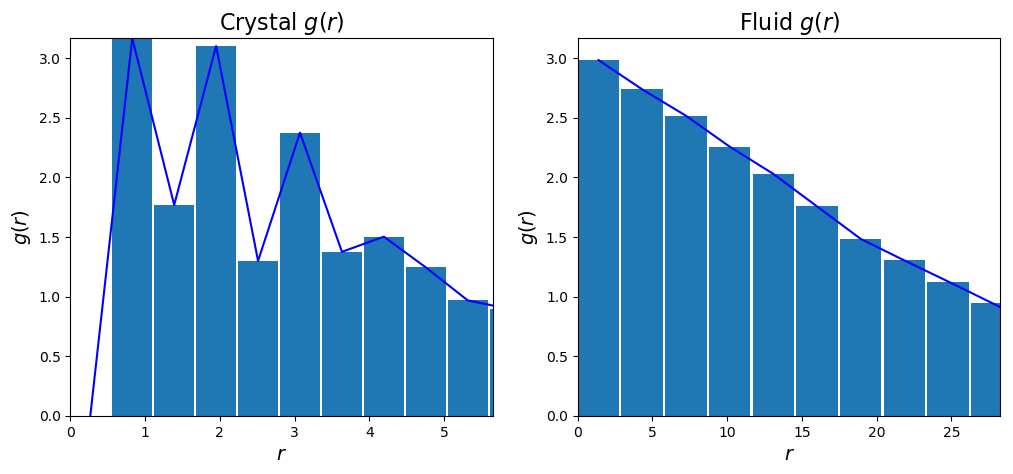

In [11]:
# Construct the bin positions
bin_centers_crystal = np.linspace(
    dr_crystal/2, dr_crystal*num_bins + dr_crystal/2, num_bins)
bin_centers_fluid = np.linspace(
    dr_fluid/2, dr_fluid*num_bins + dr_fluid/2, num_bins)

# Want figures to be comparable. The distances can vary, but the 
max_r = max(np.max(distances_crystal), np.max(distances_fluid))
max_g = max(np.max(bins_crystal), np.max(bins_fluid))

fig, axes = plt.subplots(1, 2, figsize = (12, 5))
_ = axes[0].bar(bin_centers_crystal, bins_crystal, dr_crystal)
_ = axes[0].plot(bin_centers_crystal, bins_crystal, c = 'b')
_ = axes[0].set_title("Crystal $g(r)$", fontsize = 16)
_ = axes[0].set_xlabel("$r$", fontsize = 14)
_ = axes[0].set_ylabel("$g(r)$", fontsize = 14)
_ = axes[0].set_xlim([0, L_crystal*np.sqrt(2)/2])
_ = axes[0].set_ylim([0, max_g])

_ = axes[1].bar(bin_centers_fluid, bins_fluid, dr_fluid)
_ = axes[1].plot(bin_centers_fluid, bins_fluid, c = 'b')
_ = axes[1].set_title("Fluid $g(r)$", fontsize = 16)
_ = axes[1].set_xlabel("$r$", fontsize = 14)
_ = axes[1].set_ylabel("$g(r)$", fontsize = 14)
_ = axes[1].set_xlim([0, L_fluid*np.sqrt(2)/2])
_ = axes[1].set_ylim([0, max_g])

There is a clear difference in the two histograms; both decay to 1.0 as expected, but the crystal shows a distinctly peaked structure while the fluid is much flatter.